In [ ]:
!pip install kaggle

In [ ]:
!pip install tensorboard

In [3]:
import os
import stat
import json
from ipywidgets import Password
from ipywidgets import widgets
from IPython.display import display
from IPython.display import Image

import kaggle

###### Create and place your API token

To be able to download datasets using the Kaggle API, please create and download your API token.
1. Go to [Kaggle](https://www.kaggle.com/) and log in.
2. Go to your account (locate your profile image at the top-right corner of the page)

![](kaggle_account.png)

3. Scroll down your account page until you find the API cell, and click on the "Create new API token" button.

![](api_key.png)

This will download a file called `kaggle.json`. This file contains the credentials that the Kaggle API will need, but you need to place it in the correct folder. 

In [4]:
user = widgets.Text(
    placeholder='Insert your Kaggle username!',
    description='User',
    disabled=False
)

pwd = Password(
    description='Key',
    placeholder='Insert key for user {}'.format(user.value)
)

def callback(wdgt):
    folder = os.path.expanduser('~/.kaggle')
    os.makedirs(folder, exist_ok=True)
    file = '{}/kaggle.json'.format(folder)
    with open(file, 'w') as kaggle_file:
        json.dump({
            'username': user.value,
            'key': wdgt.value
        }, kaggle_file)
        
        print("Credentials created in {}".format(folder))
    os.chmod(file, stat.S_IREAD | stat.S_IWRITE)

user.on_submit(lambda wdg: display(pwd))
pwd.on_submit(callback)

display(user)

Text(value='', description='User', placeholder='Insert your Kaggle username!')

In [5]:
import kaggle

DATASET_FOLDER = './diabetic_retinopathy'
os.makedirs(DATASET_FOLDER, exist_ok=True)

In [6]:
kaggle.api.authenticate()

In [7]:
!kaggle datasets list -s Retinopathy

ref                                                           title                                                size  lastUpdated          downloadCount  voteCount  usabilityRating  
------------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
tanlikesmath/diabetic-retinopathy-resized                     Diabetic Retinopathy (resized)                        7GB  2019-05-08 01:48:17           6411        249  0.5882353        
sovitrath/diabetic-retinopathy-224x224-gaussian-filtered      Diabetic Retinopathy 224x224 Gaussian Filtered      427MB  2020-02-18 02:33:27           1379         70  0.88235295       
benjaminwarner/resized-2015-2019-blindness-detection-images   Resized 2015 & 2019 Blindness Detection Images       17GB  2019-07-03 04:01:09           2762         71  0.7058824        
google-brain/messidor2-dr-grades                              MESSIDOR

In [8]:
target_dataset = "sovitrath/diabetic-retinopathy-224x224-2019-data"

In [9]:
kaggle.api.dataset_download_files(target_dataset, 
                                  path=DATASET_FOLDER, unzip=True)

# Diabetic Retinopathy

Diabetic retinopathy is a condition in which diabetes damages the health of the eyes. 

It is a major cause of blindness, especially in the developing world. 

The **fundus** is the interior area of the eye that’s opposite to the lens. 

A common strategy for diagnosis of diabetic retinopathy is for doctors to view an image of the patient’s fundus and label it manually. 

Significant work has gone into "fundus photography" which develops techniques to capture patient fundus images.

![](diabetic_retinopathy/colored_images/No_DR/0a4e1a29ffff.png)

The **learning challenge** for diabetic retinopathy is to design an algorithm that can classify a patient’s disease progress given an image of the patients’ fundus. At present, making such predictions requires skilled doctors or technicians. 

The hope is that a machine learning system could accurately predict disease progression from patient fundus images. 

This could provide patients with a cheap method of understanding their risk, which they could use before consulting a more expensive expert doctor for a diagnosis.

In [10]:
# imports
import matplotlib.pyplot as plt
import numpy as np

import torch
import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [11]:
# Transformers

# transforms
transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))])

### Introducing TorchVision

The `torchvision` package consists of popular datasets, model architectures, and common image transformations for computer vision.

Among the many features provided by `torchVision`, there is a special `Dataset` class called `ImageDataFolder`

(*from the documentation*)
>A generic data loader where the images are arranged in this way:

    root/dog/xxx.png
    root/dog/xxy.png
    root/dog/xxz.png

    root/cat/123.png
    root/cat/nsdf3.png
    root/cat/asd932_.png

In [12]:
!ls ./diabetic_retinopathy/colored_images

Mild           Moderate       No_DR          Proliferate_DR Severe


In [13]:
# datasets

from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

db_retinopathy_dataset = ImageFolder(root='./diabetic_retinopathy/colored_images', transform=transform)

In [14]:
len(db_retinopathy_dataset)

3662

###### Splitting Train and Test using torch `Subset`

In [15]:
from torch.utils.data import Subset
from sklearn.model_selection import train_test_split
import numpy as np

# in the simplest cases, no stratification is applied - we will change it later
sample_indices = np.arange(3662)

train_samples, test_samples = train_test_split(sample_indices, test_size=.2, random_state=42)

In [16]:
trainset = Subset(db_retinopathy_dataset, train_samples)
testset = Subset(db_retinopathy_dataset, test_samples)

In [17]:
# dataloaders
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                        shuffle=True, num_workers=2)


testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                        shuffle=False, num_workers=2)

In [18]:
# constant for classes
classes = ('Mild', 'Moderate', 'No_DR', 'Proliferate_DR', 'Severe')

In [19]:
# helper function to show an image
# (used in the `plot_classes_preds` function below)
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

We’ll define a similar model architecture from that tutorial, making only minor modifications to account for the fact that the images are now one channel instead of three and 28x28 instead of 32x32:

In [47]:
class DBRNet(nn.Module):
    def __init__(self):
        super(DBRNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 53 * 53, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 5)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 53 * 53)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = DBRNet()

We’ll define the same `optimizer` and `criterion` from before:

In [48]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

### TensorBoard Setup

Now we’ll set up TensorBoard, importing `tensorboard` from `torch.utils` and defining a `SummaryWriter`, our key object for writing information to TensorBoard.

In [44]:
from torch.utils.tensorboard import SummaryWriter

# default `log_dir` is "runs" - we'll be more specific here
writer = SummaryWriter('runs/db_retinopathy')

Note that this line alone creates a `runs/db_retinopathy` folder.

##### Writing to TensorBoard

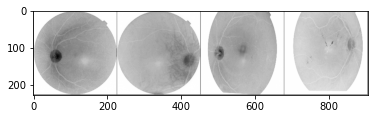

In [45]:
# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# create grid of images
img_grid = torchvision.utils.make_grid(images)

# show images
matplotlib_imshow(img_grid, one_channel=True)

# write to tensorboard
writer.add_image('diabetic_retinopathy_batch', img_grid)

###### Tensorboard

Now running

```
tensorboard --logdir=runs
```

Now you know how to use TensorBoard! 

$\rightarrow$ [http://localhost:6006](http://localhost:6006)

This example, however, could be done in a Jupyter Notebook - where TensorBoard really excels is in creating interactive visualizations. We’ll cover one of those next, and several more by the end of the tutorial.

One of TensorBoard’s strengths is its ability to visualize complex model structures. Let’s visualize the model we built.

In [49]:
writer.add_graph(net, images)
writer.close()

Now upon refreshing TensorBoard you should see a **Graphs** tab.

Go ahead and double click on “Net” to see it expand, seeing a detailed view of the individual operations that make up the model.

TensorBoard has a very handy feature for visualizing high dimensional data such as image data in a lower dimensional space; we’ll cover this next.

### Adding a “Projector” to TensorBoard

We can visualize the lower dimensional representation of higher dimensional data via the add_embedding method

In [25]:
try:
    import tensorflow as tf
    ## Patch
    import tensorboard as tb
    tf.io.gfile = tb.compat.tensorflow_stub.io.gfile
except ImportError:
    pass

In [26]:
images, labels = next(iter(DataLoader(trainset, shuffle=True, batch_size=50)))

In [27]:
images.shape

torch.Size([50, 3, 224, 224])

In [28]:
labels.shape

torch.Size([50])

In [29]:
# select random images and their target indices
images, labels = next(iter(DataLoader(trainset, shuffle=True, batch_size=50)))

# get the class labels for each image
class_labels = [classes[lab] for lab in labels]

# log embeddings
features = images.view(-1, 224*224*3)
writer.add_embedding(features,
                     metadata=class_labels,
                     label_img=images)
writer.close()

Now in the “Projector” tab of TensorBoard, you can see these 100 images - each of which is 784 dimensional - projected down into three dimensional space. Furthermore, this is interactive: you can click and drag to rotate the three dimensional projection. Finally, a couple of tips to make the visualization easier to see: select “color: label” on the top left, as well as enabling “night mode”, which will make the images easier to see since their background is white:

### Tracking model training with TensorBoard

In the previous example, we simply printed the model’s running loss every `2000` iterations. 

Now, we’ll instead log the running loss to TensorBoard, along with a view into the predictions the model is making via the `plot_classes_preds` function.

### Tracking model training with TensorBoard

In the previous example, we simply printed the model’s running loss every `2000` iterations. 

Now, we’ll instead log the running loss to TensorBoard, along with a view into the predictions the model is making via the `plot_classes_preds` function.

In [30]:
# helper functions

def images_to_probs(net, images):
    '''
    Generates predictions and corresponding probabilities from a trained
    network and a list of images
    '''
    output = net(images)
    # convert output probabilities to predicted class
    _, preds_tensor = torch.max(output, 1)
    preds = np.squeeze(preds_tensor.numpy())
    return preds, [F.softmax(el, dim=0)[i].item() for i, el in zip(preds, output)]

In [50]:
def plot_classes_preds(net, images, labels):
    '''
    Generates matplotlib Figure using a trained network, along with images
    and labels from a batch, that shows the network's top prediction along
    with its probability, alongside the actual label, coloring this
    information based on whether the prediction was correct or not.
    Uses the "images_to_probs" function.
    '''
    preds, probs = images_to_probs(net, images)
    # plot the images in the batch, along with predicted and true labels
    fig = plt.figure(figsize=(12, 48))
    for idx in np.arange(4):
        ax = fig.add_subplot(1, 4, idx+1, xticks=[], yticks=[])
        matplotlib_imshow(images[idx], one_channel=True)
        ax.set_title("{0}, {1:.1f}%\n(label: {2})".format(
            classes[preds[idx]],
            probs[idx] * 100.0,
            classes[labels[idx]]),
                    color=("green" if preds[idx]==labels[idx].item() else "red"))
    return fig

Finally, let’s train the model using the same model training code from the prior tutorial, but writing results to TensorBoard every `1000` batches instead of printing to console; this is done using the `add_scalar` function.

In addition, as we train, we’ll generate an image showing the model’s predictions vs. the actual results on the four images included in that batch.

In [51]:
running_loss = 0.0
for epoch in range(1):  # loop over the dataset multiple times

    for i, data in enumerate(trainloader, 0):

        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 1000 == 999:    # every 1000 mini-batches...

            # ...log the running loss
            writer.add_scalar('training loss',
                            running_loss / 1000,
                            epoch * len(trainloader) + i)

            # ...log a Matplotlib Figure showing the model's predictions on a
            # random mini-batch
            writer.add_figure('predictions vs. actuals',
                            plot_classes_preds(net, inputs, labels),
                            global_step=epoch * len(trainloader) + i)
            running_loss = 0.0
print('Finished Training')

Finished Training


You can now look at the scalars tab to see the running loss plotted over the 15,000 iterations of training

In addition, we can look at the predictions the model made on arbitrary batches throughout learning. See the “Images” tab and scroll down under the “predictions vs. actuals” visualization to see this; this shows us that, for example, after just 3000 training iterations, the model was already able to distinguish between visually distinct classes such as shirts, sneakers, and coats, though it isn’t as confident as it becomes later on in training

### Model Assessment

In [52]:
# 1. gets the probability predictions in a test_size x num_classes Tensor
# 2. gets the preds in a test_size Tensor
# takes ~10 seconds to run
class_probs = []
class_preds = []
with torch.no_grad():
    for data in testloader:
        images, labels = data
        output = net(images)
        class_probs_batch = [F.softmax(el, dim=0) for el in output]
        _, class_preds_batch = torch.max(output, 1)

        class_probs.append(class_probs_batch)
        class_preds.append(class_preds_batch)

test_probs = torch.cat([torch.stack(batch) for batch in class_probs])
test_preds = torch.cat(class_preds)

In [53]:
# helper function
def add_pr_curve_tensorboard(class_index, test_probs, test_preds, global_step=0):
    '''
    Takes in a "class_index" from 0 to 9 and plots the corresponding
    precision-recall curve
    '''
    tensorboard_preds = test_preds == class_index
    tensorboard_probs = test_probs[:, class_index]

    writer.add_pr_curve(classes[class_index],
                        tensorboard_preds,
                        tensorboard_probs,
                        global_step=global_step)
    writer.close()

# plot all the pr curves
for i in range(len(classes)):
    add_pr_curve_tensorboard(i, test_probs, test_preds)

You will now see a “PR Curves” tab that contains the precision-recall curves for each class. 